In [1]:
import matplotlib.pyplot as pl
import numpy as np
import json
import glob
from datetime import datetime

# CLASS model
from model import Model, Model_input

In [2]:
"""
Help functions.
"""
def load_json(json_file):
    """
    Load `json_file` from disk into dict.
    """
    with open(json_file, 'r', encoding='utf-8') as f:
        data = json.load(f)

    # Cast lists to arrays.
    for key,value in data.items():
        if isinstance(value, list):
            data[key] = np.array(value)

    return data

In [5]:
"""
Help function that parses/runs a single case.
"""

def run_case(case):

    settings = load_json(f'json/{case}.json')
    input = Model_input()

    start_date = datetime.fromisoformat(settings['start_time'])

    """
    Input for CLASS. Variables set to -1 are time or height dependent.
    """
    input.runtime = settings['time'].size * 3600
    input.dt = 60.

    # mixed-layer variables
    input.sw_ml      = True                     # mixed-layer model switch
    input.sw_shearwe = False                    # Shear growth ABL switch
    input.sw_fixft   = True                     # Fix the free-troposphere switch
    input.h          = settings['zi']           # initial ABL height [m]
    input.Ps         = settings['ps']           # surface pressure [Pa]
    input.divU       = settings['div']          # horizontal large-scale divergence of wind [s-1]
    input.fc         = settings['fc']           # Coriolis parameter [s-1]

    input.theta      = settings['thl']          # initial mixed-layer potential temperature [K]
    input.dtheta     = settings['dthl']         # initial temperature jump at h [K]
    input.gammatheta = -1                       # free atmosphere potential temperature lapse rate [K m-1]
    input.advtheta   = 0.                       # advection of heat [K s-1]
    input.beta       = 0.2                      # entrainment ratio for virtual heat [-]
    input.wtheta     = -1                       # surface kinematic heat flux [K m s-1]

    input.q          = settings['qt']           # initial mixed-layer specific humidity [kg kg-1]
    input.dq         = settings['dqt']          # initial specific humidity jump at h [kg kg-1]
    input.gammaq     = -1                       # free atmosphere specific humidity lapse rate [kg kg-1 m-1]
    input.advq       = 0                        # advection of moisture [kg kg-1 s-1]
    input.wq         = -1                       # surface kinematic moisture flux [kg kg-1 m s-1]

    input.CO2        = 420                      # mixed-layer CO2 [ppm]
    input.dCO2       = 0                        # initial CO2 jump at h [ppm]
    input.gammaCO2   = 0                        # free atmosphere CO2 lapse rate [ppm m-1] 
    input.advCO2     = 0                        # advection of CO2 [ppm s-1]
    input.wCO2       = 0                        # surface kinematic CO2 flux [ppm m s-1]

    input.sw_wind    = True                     # prognostic wind switch
    input.u          = settings['u']            # initial mixed-layer u-wind speed [m s-1]
    input.du         = settings['du']           # initial u-wind jump at h [m s-1]
    input.gammau     = -1                       # free atmosphere u-wind speed lapse rate [s-1]
    input.advu       = 0                        # advection of u-wind [m s-2]

    input.v          = settings['v']            # initial mixed-layer v-wind speed [m s-1]
    input.dv         = settings['dv']           # initial v-wind jump at h [m s-1]
    input.gammav     = -1                       # free atmosphere v-wind speed lapse rate [s-1]
    input.advv       = 0                        # advection of v-wind [m s-2]

    # surface layer variables
    input.sw_sl      = True                     # surface layer switch
    input.z0m        = settings['z0m']          # roughness length for momentum [m] <------- ??
    input.z0h        = settings['z0h']          # roughness length for scalars [m] <------- ??

    # radiation parameters
    input.sw_rad     = False                    # radiation switch
    input.tstart     = start_date.hour          # time of the day [h UTC]
    input.dFz        = 0                        # cloud top radiative divergence [W m-2] 

    # land surface parameters
    input.sw_ls      = False                    # land surface switch

    # Cumulus parameters
    input.sw_cu      = True                     # Cumulus parameterization switch
    input.dz_h       = 200                      # Transition layer thickness [m]

    # Time/height dependent variables.
    time = settings['time'] * 3600
    input.timedep = {
        'wtheta': (time, settings['wthl']),
        'wq':     (time, settings['wqt'])}

    input.heightdep = {
        'gammatheta': (np.array([settings['zi'], settings['z1_thl'], 4000]), np.array([settings['gamma_thl_1'], settings['gamma_thl_2']])),
        'gammaq':     (np.array([settings['zi'], settings['z1_qt'],  4000]), np.array([settings['gamma_qt_1'],  settings['gamma_qt_2' ]])),
        'gammau':     (np.array([settings['zi'], settings['z1_u'],   4000]), np.array([settings['gamma_u_1'],   settings['gamma_u_2'  ]])),
        'gammav':     (np.array([settings['zi'], settings['z1_v'],   4000]), np.array([settings['gamma_v_1'],   settings['gamma_v_2'  ]]))}

    model = Model(input)
    model.run()


    """
    Plot!
    """
    out = model.out

    pl.figure(figsize=(7,5), layout='constrained')
    pl.suptitle(f'{case.title()} ({start_date})')
    ncol = 3
    nrow = 3
    sp = 1

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.h)
    pl.ylabel(r'$h$ (m)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.theta)
    pl.ylabel(r'$\langle \theta \rangle$ (K)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.q*1000)
    pl.ylabel(r'$\langle q \rangle$ (g/kg)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.u)
    pl.ylabel(r'$\langle u \rangle$ (m/s)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.v)
    pl.ylabel(r'$\langle v \rangle$ (m/s)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.wtheta*1.2*1005)
    pl.ylabel(r'H (W/m$^2$)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.wq*1.2*2.5e6)
    pl.ylabel(r'LE (W/m$^2$)')
    pl.xlabel('time (h UTC)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.ac)
    pl.ylabel(r'cloud-core (-)')
    pl.xlabel('time (h UTC)')

    pl.subplot(nrow, ncol, sp); sp+=1
    pl.plot(out.t, out.RH_s*100)
    pl.ylabel(r'RH surface (%)')
    pl.xlabel('time (h UTC)')

/home/bart/meteo/projects_git/2024_EWED/mxl_from_LS2D/model.py:455: RuntimeWarning: divide by zero encountered in scalar divide
  self.ac     = max(0., 0.5 + (0.36 * np.arctan(1.55 * ((self.q - qsat(self.T_h, self.P_h)) / self.q2_h**0.5))))


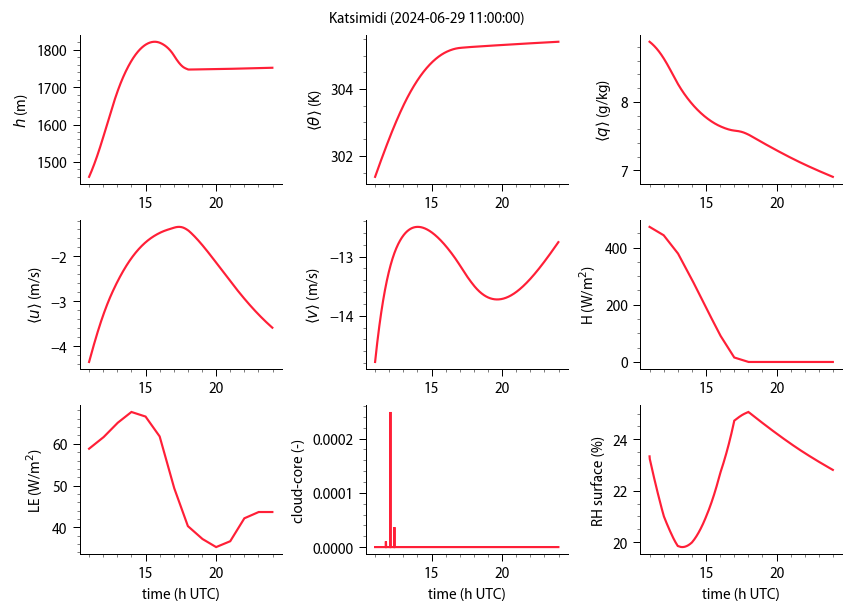

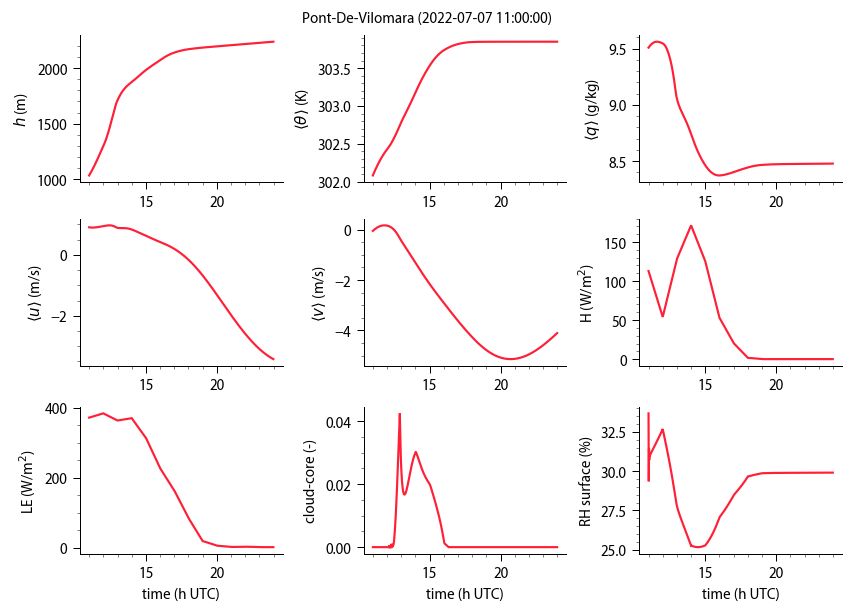

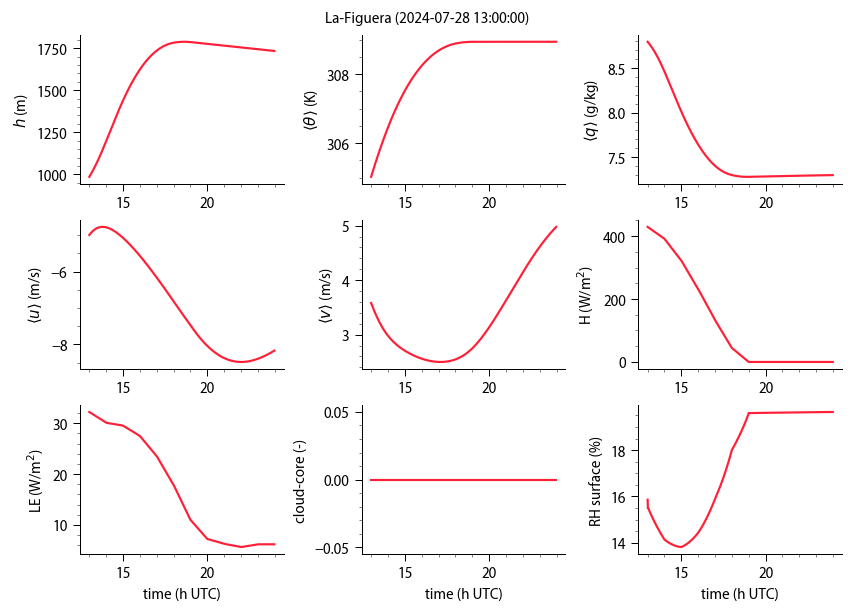

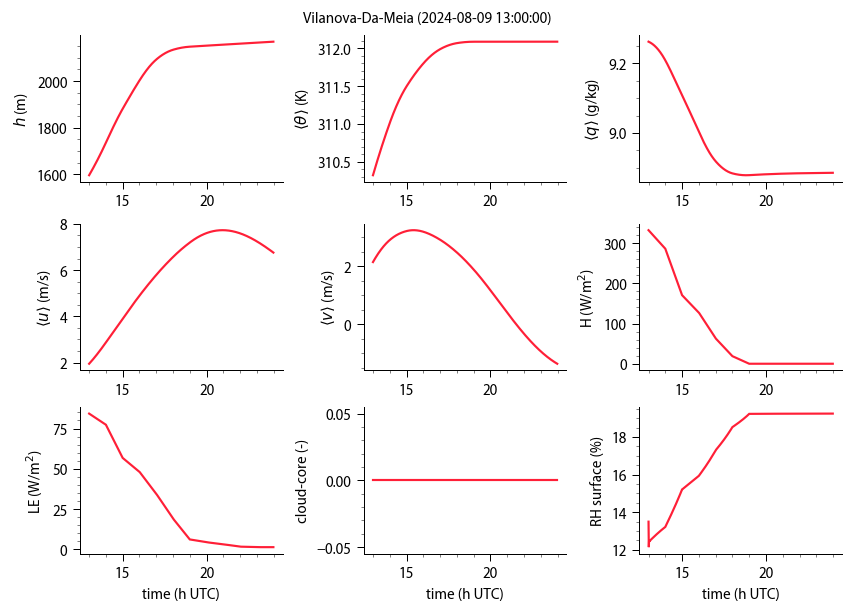

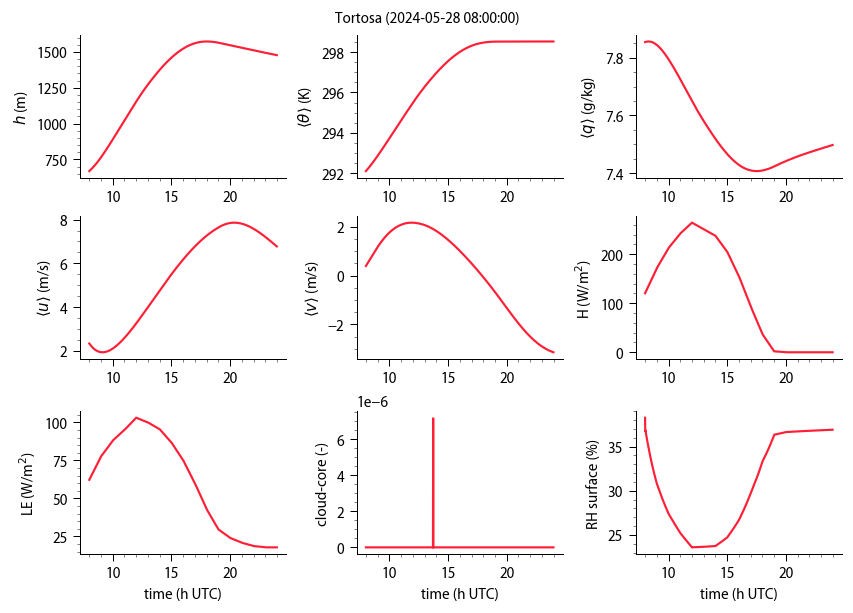

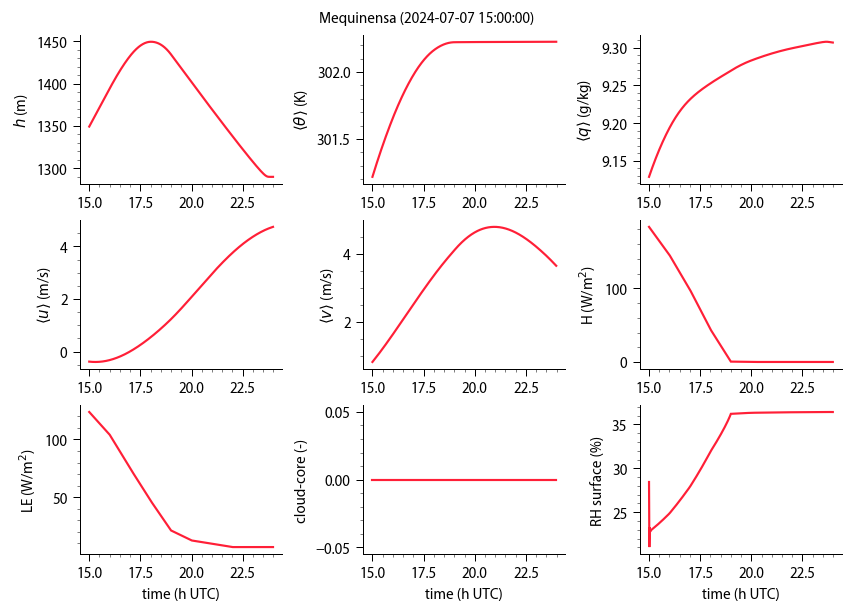

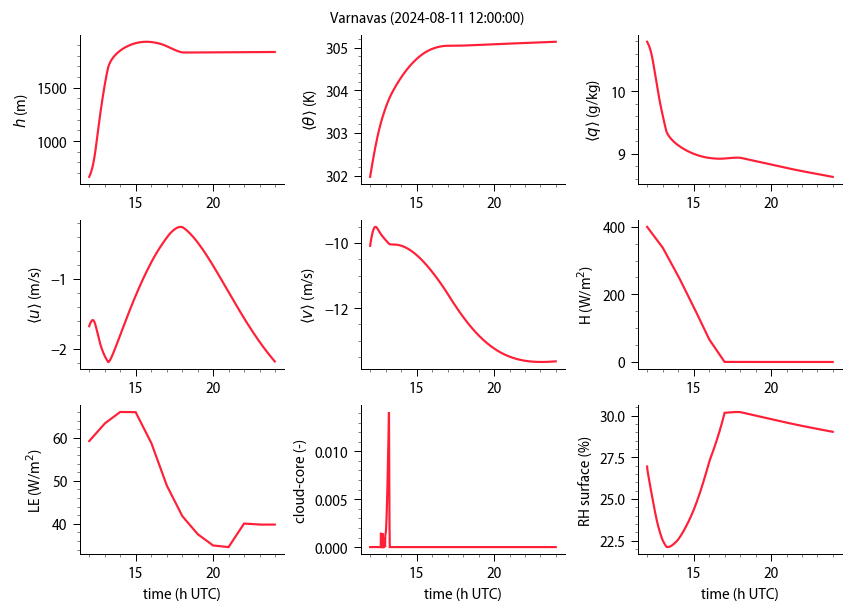

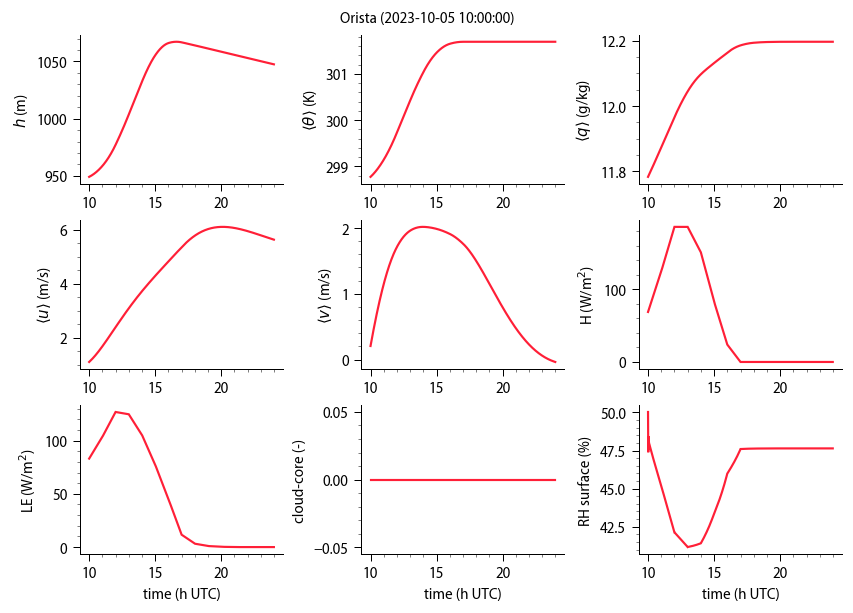

In [6]:
"""
Run all cases!
"""
pl.close('all')

cases = glob.glob('json/*.json')
for case in cases:
    name = case.split('/')[-1].split('.')[0]
    run_case(name)